# DSLab Homework3 - Uncovering World Events using Twitter Hashtags

## ... and learning about Spark `DataFrames` along the way

In this notebook, we will use temporal information about Twitter hashtags to discover trending topics and potentially uncover world events as they occurred. 

## Hand-in Instructions:

- __Due: 27.04.2021 23:59:59 CET__
- your project must be private
- `git push` your final verion to the master branch of your group's Renku repository before the due date
- check if `Dockerfile`, `environment.yml` and `requirements.txt` are properly written
- add necessary comments and discussion to make your codes readable

## Hashtags

The idea here is that when an event is happening and people are having a conversation about it on Twitter, a set of uniform hashtags that represent the event spontaneously evolves. Twitter users then use those hashtags to communicate with one another. Some hashtags, like `#RT` for "retweet" or just `#retweet` are used frequently and don't tell us much about what is going on. But a sudden appearance of a hashtag like `#oscars` probably indicates that the oscars are underway. For a particularly cool example of this type of analysis, check out [this blog post about earthquake detection using Twitter data](https://blog.twitter.com/official/en_us/a/2015/usgs-twitter-data-earthquake-detection.html) (although they search the text and not necessarily hashtags).

## Initialize the environment

In [1]:
%%local
import os
username = os.environ['JUPYTERHUB_USER']

# set the application name as "<your_gaspar_id>-homework3"
get_ipython().run_cell_magic('configure', line="-f", cell='{ "name":"%s-homework3", "executorMemory":"4G", "executorCores":4, "numExecutors":10, "driverMemory": "4G" }' % username)

Send `username` to Spark kernel, which will frist start the Spark application if there is no active session.

In [2]:
%%send_to_spark -i username -t str -n username

Starting Spark application


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Successfully passed 'username' as 'username' to Spark kernel

In [3]:
print('We are using Spark %s' % spark.version)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

We are using Spark 2.3.2.3.1.4.0-315

In [4]:
%%help

## PART I: Set up (5 points)

The twitter stream data is downloaded from [Archive Team: The Twitter Stream Grab](https://archive.org/details/twitterstream), which is a collection of a random sample of all tweets. We have parsed the stream data and prepared the twitter hashtag data of __2020__, a very special and different year in many ways. Let's see if we can see any trends about all these events of 2020 in the Twitter data. 

<div style="font-size: 100%" class="alert alert-block alert-danger">
<b>Disclaimer</b>
<br>
This dataset contains unfiltered data from Twitter. As such, you may be exposed to tweets/hashtags containing vulgarities, references to sexual acts, drug usage, etc.
</div>

### a) Load data - 1/10

Load the **orc** data from `/data/twitter/orc/hashtags/` into a Spark dataframe using the appropriate `SparkSession` method. 

Look at the first few rows of the dataset - note the timestamp and its units!

In [5]:
df = spark.read.orc("/data/twitter/orc/hashtags/")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [6]:
df.printSchema()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- timestamp_s: long (nullable = true)
 |-- id: long (nullable = true)
 |-- lang: string (nullable = true)
 |-- hashtag: string (nullable = true)

In [7]:
#Time in UNIX time i.e. number of seconds that have enlapsed from 01.01.1970
df.show(n=5, truncate=False, vertical=False)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------+-------------------+----+------------+
|timestamp_s|id                 |lang|hashtag     |
+-----------+-------------------+----+------------+
|1609427280 |1344661591460098052|ko  |NCT         |
|1609427280 |1344661591460098052|ko  |NCT127      |
|1609427280 |1344661591460098052|ko  |TAEYONG     |
|1609427280 |1344661591460098052|ko  |태용          |
|1609427280 |1344661591460098052|ko  |HAPPYNEWYEAR|
+-----------+-------------------+----+------------+
only showing top 5 rows

<div style="font-size: 100%" class="alert alert-block alert-info">
    <b>Cluster Usage:</b> As there are many of you working with the cluster, we encourage you to
    <ul>
        <li>prototype your queries on small data samples before running them on whole datasets</li>
        <li>save your intermediate results in your own directory at hdfs <b>"/user/&lt;your-gaspar-id&gt;/"</b></li>
    </ul>
</div>

For example:

```python
    # create a subset of original dataset
    df_sample = df.sample(0.01)
    
    # save as orc
    df_sample.write.orc('/user/%s/sample.orc' % username, mode='overwrite')

```

### b) Functions - 2/10

In [8]:
import pyspark.sql.functions as F

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

__User-defined functions__

A neat trick of spark dataframes is that you can essentially use something very much like an RDD `map` method but without switching to the RDD. If you are familiar with database languages, this works very much like e.g. a user-defined function in SQL. 

So, for example, if we wanted to make a user-defined python function that returns the hashtags in lowercase, we could do something like this:

In [9]:
@F.udf
def lowercase(text):
    """Convert text to lowercase"""
    return text.lower()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

The `@F.udf` is a "decorator" -- this is really handy python syntactic sugar and in this case is equivalent to:

```python
def lowercase(text):
    return text.lower()
    
lowercase = F.udf(lowercase)
```

It basically takes our function and adds to its functionality. In this case, it registers our function as a pyspark dataframe user-defined function (UDF).

Using these UDFs is very straightforward and analogous to other Spark dataframe operations. For example:

In [10]:
df.select(lowercase(df.hashtag)).show(n=5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------------+
|lowercase(hashtag)|
+------------------+
|               nct|
|            nct127|
|           taeyong|
|                태용|
|      happynewyear|
+------------------+
only showing top 5 rows

__Built-in functions__

Using a framework like Spark is all about understanding the ins and outs of how it functions and knowing what it offers. One of the cool things about the dataframe API is that many functions are already defined for you (turning strings into lowercase being one of them). Find the [Spark python API documentation](https://spark.apache.org/docs/2.3.2/api/python/index.html). Look for the `sql` section and find the listing of `sql.functions`. Repeat the above (turning hashtags into lowercase) but use the built-in function.

In [11]:
df.select(F.lower(df.hashtag)).show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------+
|lower(hashtag)|
+--------------+
|           nct|
|        nct127|
|       taeyong|
|            태용|
|  happynewyear|
+--------------+
only showing top 5 rows

We'll work with a combination of these built-in functions and user-defined functions for the remainder of this homework. 

Note that the functions can be combined. Consider the following dataframe and its transformation:

In [12]:
from pyspark.sql import Row

# create a sample dataframe with one column "degrees" going from 0 to 180
test_df = spark.createDataFrame(spark.sparkContext.range(180).map(lambda x: Row(degrees=x)), ['degrees'])

# define a function "sin_rad" that first converts degrees to radians and then takes the sine using built-in functions
sin_rad = F.sin(F.radians(test_df.degrees))

# show the result
test_df.select(sin_rad).show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------------------+
|SIN(RADIANS(degrees))|
+---------------------+
|                  0.0|
|  0.01745240643728351|
|  0.03489949670250097|
|  0.05233595624294383|
|   0.0697564737441253|
|  0.08715574274765817|
|  0.10452846326765346|
|  0.12186934340514748|
|  0.13917310096006544|
|  0.15643446504023087|
|  0.17364817766693033|
|   0.1908089953765448|
|  0.20791169081775931|
|  0.22495105434386498|
|  0.24192189559966773|
|  0.25881904510252074|
|  0.27563735581699916|
|   0.2923717047227367|
|   0.3090169943749474|
|   0.3255681544571567|
+---------------------+
only showing top 20 rows

### c) Tweets in english - 2/10

- Create `english_df` with only english-language tweets. 
- Turn hashtags into lowercase.
- Convert the timestamp to a more readable format and name the new column as `date`.
- Sort the table in chronological order. 

Your `english_df` should look something like this:

```
+-----------+----+-----------+-------------------+
|timestamp_s|lang|    hashtag|               date|
+-----------+----+-----------+-------------------+
| 1577862000|  en| spurfamily|2020-01-01 08:00:00|
| 1577862000|  en|newyear2020|2020-01-01 08:00:00|
| 1577862000|  en|     master|2020-01-01 08:00:00|
| 1577862000|  en|  spurrific|2020-01-01 08:00:00|
| 1577862000|  en|     master|2020-01-01 08:00:00|
+-----------+----+-----------+-------------------+
```

__Note:__ 
- The hashtags may not be in english.
- [pyspark.sql.functions](https://spark.apache.org/docs/2.3.2/api/python/pyspark.sql.html#module-pyspark.sql.functions)

In [13]:
english_df = df .where(df.lang == 'en')\
                .withColumn('hashtag', F.lower(df.hashtag))\
                .withColumn("date",F.to_timestamp(df.timestamp_s))\
                .drop("id")\
                .orderBy("date")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [14]:
english_df.show(n=5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------+----+-----------+-------------------+
|timestamp_s|lang|    hashtag|               date|
+-----------+----+-----------+-------------------+
| 1577862000|  en|newyear2020|2020-01-01 08:00:00|
| 1577862000|  en| leadership|2020-01-01 08:00:00|
| 1577862000|  en|     master|2020-01-01 08:00:00|
| 1577862000|  en|  spurrific|2020-01-01 08:00:00|
| 1577862000|  en|     master|2020-01-01 08:00:00|
+-----------+----+-----------+-------------------+
only showing top 5 rows

## PART II: Twitter hashtag trends (30 points)

In this section we will try to do a slightly more complicated analysis of the tweets. Our goal is to get an idea of tweet frequency as a function of time for certain hashtags. 

Have a look [here](http://spark.apache.org/docs/2.3.2/api/python/pyspark.sql.html#module-pyspark.sql.functions) to see the whole list of custom dataframe functions - you will need to use them to complete the next set of TODO items.

### a) Top hashtags - 1/30

We used `groupBy` already in the previous notebooks, but here we will take more advantage of its features. 

One important thing to note is that unlike other RDD or DataFrame transformations, the `groupBy` does not return another DataFrame, but a `GroupedData` object instead, with its own methods. These methods allow you to do various transformations and aggregations on the data of the grouped rows. 

Conceptually the procedure is a lot like this:

![groupby](https://i.stack.imgur.com/sgCn1.jpg)

The column that is used for the `groupBy` is the `key` - once we have the values of a particular key all together, we can use various aggregation functions on them to generate a transformed dataset. In this example, the aggregation function is a simple `sum`. In the simple procedure below, the `key` will be the hashtag.


Use `groupBy`, calculate the top 5 most common hashtags in the whole english-language dataset.

This should be your result:

```
+-----------------+-------+
|          hashtag|  count|
+-----------------+-------+
|              bts|1200196|
|          endsars|1019280|
|          covid19| 717238|
|            방탄소년단| 488160|
|sarkaruvaaripaata| 480124|
+-----------------+-------+
```

In [15]:
#already tried on the full data and gave the correct answer

english_df.groupBy("hashtag").count().sort("count", ascending=False).show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------------+-------+
|          hashtag|  count|
+-----------------+-------+
|              bts|1200196|
|          endsars|1019280|
|          covid19| 717238|
|            방탄소년단| 488160|
|sarkaruvaaripaata| 480124|
+-----------------+-------+
only showing top 5 rows

### b) Daily hashtags - 2/50

Now, let's see how we can start to organize the tweets by their timestamps. Remember, our goal is to uncover trending topics on a timescale of a few days. A much needed column then is simply `day`. Spark provides us with some handy built-in dataframe functions that are made for transforming date and time fields.

- Create a dataframe called `daily_hashtag` that includes the columns `month`, `week`, `day` and `hashtag`. 
- Use the `english_df` you made above to start, and make sure you find the appropriate spark dataframe functions to make your life easier. For example, to convert the date string into day-of-year, you can use the built-in [dayofyear](http://spark.apache.org/docs/2.3.2/api/python/pyspark.sql.html#pyspark.sql.functions.dayofyear) function. 
- For the simplicity of following analysis, filter only tweets of 2020.
- Show the result.

Try to match this view:

```
+-----+----+---+-----------+
|month|week|day|    hashtag|
+-----+----+---+-----------+
|    1|   1|  1| spurfamily|
|    1|   1|  1|newyear2020|
|    1|   1|  1|     master|
|    1|   1|  1|  spurrific|
|    1|   1|  1|     master|
+-----+----+---+-----------+
```

In [16]:
daily_hashtag = english_df  .where(F.year("date")==2020)\
                            .withColumn("month",F.month("date"))\
                            .withColumn("week",F.weekofyear("date"))\
                            .withColumn("day",F.dayofyear("date"))\
                            .select("month","week","day","hashtag")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [17]:
daily_hashtag.show(n=5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----+----+---+-----------+
|month|week|day|    hashtag|
+-----+----+---+-----------+
|    1|   1|  1|newyear2020|
|    1|   1|  1| leadership|
|    1|   1|  1|  spurrific|
|    1|   1|  1|     master|
|    1|   1|  1|     master|
+-----+----+---+-----------+
only showing top 5 rows

### c) Daily counts - 2/50

Now we want to calculate the number of times a hashtag is used per day based on the dataframe `daily_hashtag`. Sort in descending order of daily counts and show the result. Call the resulting dataframe `day_counts`.

Your output should look like this:

```
+---+----------------------+----+------+
|day|hashtag               |week|count |
+---+----------------------+----+------+
|229|pawankalyanbirthdaycdp|33  |202241|
|222|hbdmaheshbabu         |32  |195718|
|228|pawankalyanbirthdaycdp|33  |152037|
|357|100freeiphone12       |52  |122068|
|221|hbdmaheshbabu         |32  |120401|
+---+----------------------+----+------+
```

<div class="alert alert-info">
<p>Make sure you use <b>cache()</b> when you create <b>day_counts</b> because we will need it in the steps that follow!</p>
</div>

In [18]:
#already tried on the full data and gave the correct answer

day_counts = daily_hashtag.groupBy("day","hashtag","week").count().sort("count", ascending=False).cache()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [19]:
day_counts.show(n=5, truncate=False)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---+----------------------+----+------+
|day|hashtag               |week|count |
+---+----------------------+----+------+
|229|pawankalyanbirthdaycdp|33  |202241|
|222|hbdmaheshbabu         |32  |195718|
|228|pawankalyanbirthdaycdp|33  |152037|
|357|100freeiphone12       |52  |122068|
|221|hbdmaheshbabu         |32  |120401|
+---+----------------------+----+------+
only showing top 5 rows

### d) Weekly average - 2/50

To get an idea of which hashtags stay popular for several days, calculate the average number of daily occurences for each week. Sort in descending order and show the top 20.

__Note:__
- Use the `week` column we created above.
- Calculate the weekly average using `F.mean(...)`.

In [20]:
day_counts.groupBy("week","hashtag").mean("count").sort("avg(count)",ascending=False).show(20)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----+--------------------+------------------+
|week|             hashtag|        avg(count)|
+----+--------------------+------------------+
|  33|pawankalyanbirthd...|          177139.0|
|  30|   maheshbabubdaycdp|           63298.0|
|  42|             endsars|55527.142857142855|
|  43|             endsars|           45180.0|
|  32|       hbdmaheshbabu|45162.857142857145|
|  19|8yrsofgabbarsingh...|           39814.0|
|  41|             endsars|32503.428571428572|
|   3|      chartbustersid|           28362.5|
|  42|             endswat|26943.833333333332|
|  35|indianstyleiconal...|           26561.5|
|  33|          vakeelsaab|26498.285714285714|
|  29|advancehbdpawanka...|26406.571428571428|
|  25|advancehbdmaheshbabu|           25593.5|
|  32|   sarkaruvaaripaata|24951.428571428572|
|  49|            2020mama|           23315.0|
|  49|            mamavote|           22234.0|
|  36|     destinedsidnaaz|           20847.0|
|  37|41daystorebelstar...|           20677.0|
|  22|   sark

### e) Ranking - 3/20

Window functions are another awesome feature of dataframes. They allow users to accomplish complex tasks using very concise and simple code. 

Above we computed just the hashtag that had the most occurrences on *any* day. Now lets say we want to know the top tweets for *each* day.  

This is a non-trivial thing to compute and requires "windowing" our data. I recommend reading this [window functions article](https://databricks.com/blog/2015/07/15/introducing-window-functions-in-spark-sql.html) to get acquainted with the idea. You can think of a window function as a fine-grained and more flexible `groupBy`. 

There are two things we need to define to use window functions:

1. the "window" to use, based on which columns (partitioning) and how the rows should be ordered 
2. the computation to carry out for each windowed group, e.g. a max, an average etc.

Lets see how this works by example. We will define a window function, `daily_window` that will partition data based on the `day` column. Within each window, the rows will be ordered by the daily hashtag count that we computed above. Finally, we will use the rank function **over** this window to give us the ranking of top tweets. 

In the end, this is a fairly complicated operation achieved in just a few lines of code! (can you think of how to do this with an RDD??)

In [21]:
from pyspark.sql import Window

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

First, we specify the window function and the ordering:

In [22]:
daily_window = Window.partitionBy('day').orderBy(F.desc('count'))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

The above window function says that we should window the data on the `day` column and order it by count. 

Now we need to define what we want to compute on the windowed data. We will start by just calculating the daily ranking of hashtags, so we can use the helpful built-in `F.rank()` and sort:

In [23]:
daily_rank = F.rank() \
              .over(daily_window) \
              .alias('rank')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Now compute the top five hashtags for each day in our data:

In [24]:
#already tried on the full data and gave very convincing results

day_counts.select("hashtag","day","count",daily_rank).where("rank<=5").show(20)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+---+-----+----+
|             hashtag|day|count|rank|
+--------------------+---+-----+----+
|         georgefloyd|148| 6266|   1|
|        2020btsfesta|148| 3455|   2|
|witnesses_of_godk...|148| 2867|   3|
|    blacklivesmatter|148| 2771|   4|
|             covid19|148| 2165|   5|
|indianstyleiconal...|243|30955|   1|
|              pushpa|243|18477|   2|
|1yearforbomonster...|243|15269|   3|
|             prabhas|243|10387|   4|
|   sarkaruvaaripaata|243| 5742|   5|
|            asimriaz| 31| 4924|   1|
|               walls| 31| 3478|   2|
|            logic301| 31| 3271|   3|
|            aslifans| 31| 2895|   4|
|        iheartawards| 31| 2873|   5|
|             covid19| 85| 8584|   1|
|         coronavirus| 85| 7070|   2|
|      animalcrossing| 85| 4231|   3|
|roudramranamrudhiram| 85| 3036|   4|
|                acnh| 85| 2777|   5|
+--------------------+---+-----+----+
only showing top 20 rows

### f) Rolling sum - 5/30

With window functions, you can also calculate the statistics of a rolling window. 

In this question, construct a 7-day rolling window (including the day and 6 days before) to calculate the rolling sum of the daily occurences for each hashtag.

Your results should be like:
- For the hashtag `covid19`:

```
+---+----+-----+-------+-----------+
|day|week|count|hashtag|rolling_sum|
+---+----+-----+-------+-----------+
| 42|   7|   85|covid19|         85|
| 43|   7|   94|covid19|        179|
| 45|   7|  192|covid19|        371|
| 46|   7|   97|covid19|        468|
| 47|   7|  168|covid19|        636|
| 48|   8|  317|covid19|        953|
| 49|   8|  116|covid19|        984|
| 51|   8|  234|covid19|       1124|
| 52|   8|  197|covid19|       1129|
| 53|   8|  369|covid19|       1401|
+---+----+-----+-------+-----------+
```

- For the hashtag `bts`:

```
+---+----+-----+-------+-----------+
|day|week|count|hashtag|rolling_sum|
+---+----+-----+-------+-----------+
|  1|   1| 2522|    bts|       2522|
|  2|   1| 1341|    bts|       3863|
|  3|   1|  471|    bts|       4334|
|  4|   1|  763|    bts|       5097|
|  5|   1| 2144|    bts|       7241|
|  6|   2| 1394|    bts|       8635|
|  7|   2| 1673|    bts|      10308|
|  8|   2| 5694|    bts|      13480|
|  9|   2| 5942|    bts|      18081|
| 10|   2| 5392|    bts|      23002|
+---+----+-----+-------+-----------+
```

In [25]:
#already tried on the full data and gave the correct answer

weekly_rolling_window = Window.partitionBy("hashtag").orderBy("day").rangeBetween(-6, 0)

weekly_sum = F.sum("count") \
              .over(weekly_rolling_window) \
              .alias('rolling_sum')


rs_counts = day_counts.select("day","week","count","hashtag",weekly_sum)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [26]:
rs_counts.filter('hashtag == "covid19"').show(n=10)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---+----+-----+-------+-----------+
|day|week|count|hashtag|rolling_sum|
+---+----+-----+-------+-----------+
| 42|   7|   85|covid19|         85|
| 43|   7|   94|covid19|        179|
| 45|   7|  192|covid19|        371|
| 46|   7|   97|covid19|        468|
| 47|   7|  168|covid19|        636|
| 48|   8|  317|covid19|        953|
| 49|   8|  116|covid19|        984|
| 51|   8|  234|covid19|       1124|
| 52|   8|  197|covid19|       1129|
| 53|   8|  369|covid19|       1401|
+---+----+-----+-------+-----------+
only showing top 10 rows

In [27]:
rs_counts.filter('hashtag == "bts"').show(n=10)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---+----+-----+-------+-----------+
|day|week|count|hashtag|rolling_sum|
+---+----+-----+-------+-----------+
|  1|   1| 2522|    bts|       2522|
|  2|   1| 1341|    bts|       3863|
|  3|   1|  471|    bts|       4334|
|  4|   1|  763|    bts|       5097|
|  5|   1| 2144|    bts|       7241|
|  6|   2| 1394|    bts|       8635|
|  7|   2| 1673|    bts|      10308|
|  8|   2| 5694|    bts|      13480|
|  9|   2| 5942|    bts|      18081|
| 10|   2| 5392|    bts|      23002|
+---+----+-----+-------+-----------+
only showing top 10 rows

### g) DIY - 15/20

Use window functions (or other techniques!) to produce lists of top few trending tweets for each week. What's a __"trending"__ tweet? Something that seems to be __suddenly growing very rapidly in popularity__. 

You should be able to identify, for example, Oscars-related hashtags in week 7 when [the 92nd Academy Awards ceremony took place](https://www.oscars.org/oscars/ceremonies/2020), COVID-related hashtags in week 11 when [WHO declared COVID-19 a pandemic](https://www.who.int/director-general/speeches/detail/who-director-general-s-opening-remarks-at-the-media-briefing-on-covid-19---11-march-2020), and other events like the movement of Black Life Matters in late May, the United States presidential elections, the 2020 American Music Awards, etc.

The final listing should be clear and concise and the flow of your analysis should be easy to follow. If you make an implementation that is not immediately obvious, make sure you provide comments either in markdown cells or in comments in the code itself.

##### Strategy - trending computation

We decided to implement a smoothed derivative by subtracting the average count in a rolling window fashion. The smooth average was set up in order to leave the possibility to a quickly increasing topic to stay in the trending even if it stagnates on high values.
Then in order to leave a chance to smaller hashtags that are rapidly increasing to be displayed, we divided by the rolling average to really get the ratio of the increase, but because we want hashtags that appear more often to have a moderate priority we multiplied by the logarithm of the count (those distribution tend to be heavily tailed, therefore a logarithm is perfectly suited to the situation).
And we also added a smoothing term inside the parenthesis to get more significant result on edge cases, for example on week 1, when the rolling average is equal to the current count. This is like giving every hashtag a by-default 25% increase, it flattens a bit the benefit of having a big increase and favor a great number of occurences.

$$Trending\_score = \log(count) \cdot (0.25+\frac{count-rolling\_avg}{rolling\_avg})$$


In [28]:
# Initializing apropriate windows
window_size=4

rolling_window_over_weeks = Window.partitionBy("hashtag").orderBy("week").rangeBetween(1-window_size, 0)

weeks_avg = F.mean("count").over(rolling_window_over_weeks)

weeks_std = F.stddev("count").over(rolling_window_over_weeks)

ranked_score=F.rank().over(Window.partitionBy('week').orderBy(F.desc('score')))


trendings=daily_hashtag.groupBy("hashtag","week")\
                        .count()\
                        .withColumn("rolling_avg",weeks_avg)\
                        .withColumn("score",F.log(F.col("count"))*(0.5+(F.col("count") - F.col("rolling_avg"))/F.col("rolling_avg")))\
                        .drop("count")\
                        .drop("rolling_avg")\
                        .fillna(value=0)\
                        .withColumn("rank",ranked_score)\
                        .drop("score")\
                        .where("rank<=15")\

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [29]:
interesting_weeks=[7,11,22,45,47]

for week in interesting_weeks:
    print("Top 15 of week {0}".format(week))
    print(trendings.where("week={0}".format(week)).show(15))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Top 15 of week 7
+------------------+----+----+
|           hashtag|week|rank|
+------------------+----+----+
|            oscars|   7|   1|
|     valentinesday|   7|   2|
| valentinesday2020|   7|   3|
|happyvalentinesday|   7|   4|
|        daytona500|   7|   5|
|               kca|   7|   6|
| map_of_the_soul_7|   7|   7|
|        queenradio|   7|   8|
|          parasite|   7|   9|
|       allaboutluv|   7|  10|
|    sidnaazforever|   7|  11|
|    fixedwinnersid|   7|  12|
|        oscars2020|   7|  13|
|    womeninscience|   7|  14|
|             oscar|   7|  15|
+------------------+----+----+

None
Top 15 of week 11
+--------------------+----+----+
|             hashtag|week|rank|
+--------------------+----+----+
|                 엔시티|  11|   1|
|100asianheartthro...|  11|   2|
|            covid_19|  11|   3|
|             covid19|  11|   4|
|            covidー19|  11|   5|
|             warzone|  11|   6|
|   heartbreakweather|  11|   7|
|          boywithluv|  11|   8|
|      

## PART III: Hashtag clustering (25 points)

### a) Feature vector - 3/25

- Create a dataframe `daily_hashtag_matrix` that consists of hashtags as rows and daily counts as columns (hint: use `groupBy` and methods of `GroupedData`). Each row of the matrix represents the time series of daily counts of one hashtag. Cache the result.

- Create the feature vector which consists of daily counts using the [`VectorAssembler`](https://spark.apache.org/docs/2.3.2/api/python/pyspark.ml.html#pyspark.ml.feature.VectorAssembler) from the Spark ML library. Cache the result.

In [49]:
from pyspark.ml.feature import VectorAssembler

daily_hashtag_matrix = daily_hashtag.select("day","hashtag")\
                                    .groupBy("hashtag")\
                                    .pivot("day")\
                                    .count().fillna(0).cache()

df_vector = VectorAssembler(inputCols=daily_hashtag_matrix.columns[1:], outputCol="features")\
                                .transform(daily_hashtag_matrix)\
                                .select('hashtag','features').cache()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### b) Visualization - 2/25

Visualize the time sereis you just created. 

- Select a few interesting hashtags you identified above. `isin` method of DataFrame columns might be useful.
- Convert the subset DataFrame as pandas DataFrame with the method `toPandas`.
- Plot the time series for the chosen hashtags with matplotlib. To visualize in this PySpark kernel, you need the magic `%matplot plt`. For details, please check [here](https://raw.githubusercontent.com/jupyter-incubator/sparkmagic/master/screenshots/matplotlib.png).

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

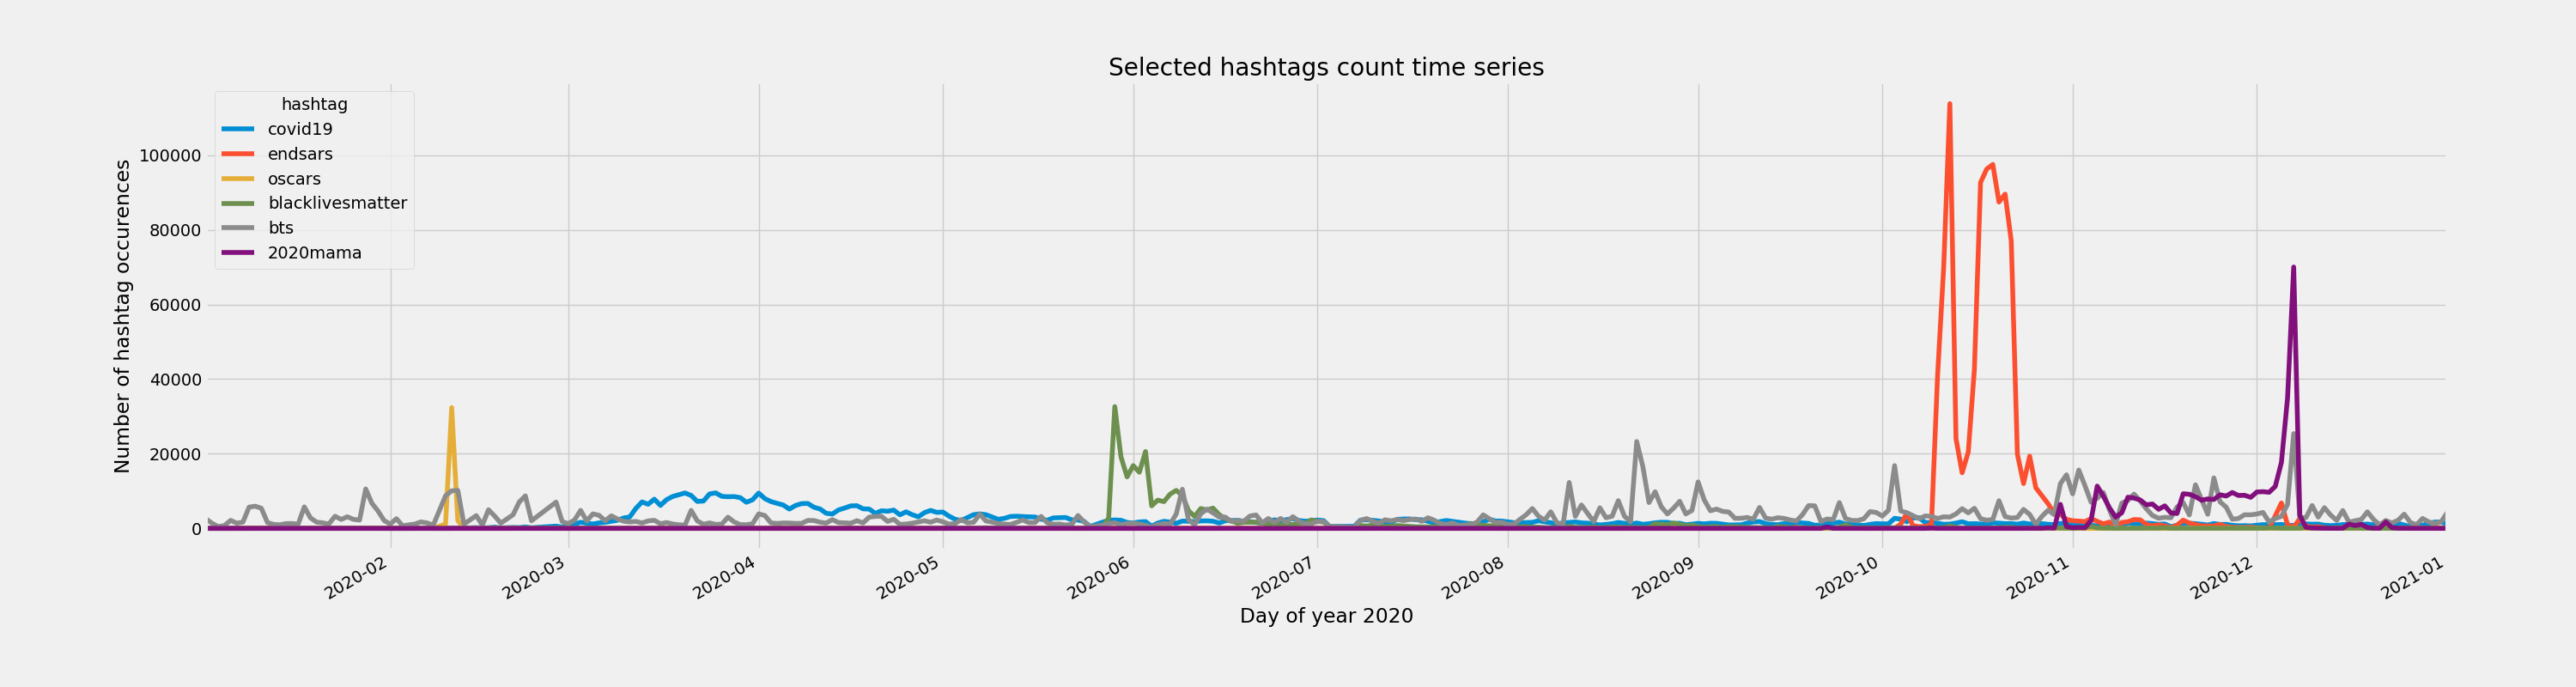

In [50]:
import matplotlib
matplotlib.use('agg')
import matplotlib.pylab as plt
import datetime

plt.rcParams['figure.figsize'] = (30,8)
plt.rcParams['font.size'] = 12
plt.style.use('fivethirtyeight')

# selecting few interesting hashtags
selected_hashtags = ["covid19", "bts", "endsars","oscars","2020mama","blacklivesmatter"]
plot_df = daily_hashtag_matrix[daily_hashtag_matrix.hashtag.isin(selected_hashtags)].toPandas().set_index("hashtag").transpose()
base_date = datetime.datetime(2020,1,1)
plot_df.index = plot_df.index.map(lambda t: base_date + datetime.timedelta(days=int(t)))

plot_df.plot()
#plt.yscale('log')  # We found the vizualisation a little better without log-scale
                    # as we can still see the peaks and have a better feeling of magnitudes 
plt.title("Selected hashtags count time series")
plt.xlabel("Day of year 2020")
plt.ylabel("Number of hashtag occurences")

%matplot plt

### c) KMeans clustering - 20/25

Use KMeans to cluster hashtags based on the daily count timeseries you created above. Train the model and calculate the cluster membership for all hashtags. Again, be creative and see if you can get meaningful hashtag groupings. 

Validate your results by showing certain clusters, for example, those including some interesting hashtags you identified above. Do they make sense?

Make sure you document each step of your process well so that your final notebook is easy to understand even if the result is not optimal or complete. 

__Note:__ 
- Additional data cleaning, feature engineering, deminsion reduction, etc. might be necessary to get meaningful results from the model. 
- For available methods, check [pyspark.sql.functions documentation](https://spark.apache.org/docs/2.3.2/api/python/pyspark.sql.html#module-pyspark.sql.functions), [Spark MLlib Guide](https://spark.apache.org/docs/2.3.2/ml-guide.html) and [pyspark.ml documentation](https://spark.apache.org/docs/2.3.2/api/python/pyspark.ml.html).

In [32]:
from pyspark.ml.feature import PCA
from pyspark.ml.clustering import KMeans

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Preprocessing
The goal of the following analyis is to cluster hashtags based on the daily count timeseries. In general, we don't have a lot of information about hashtags which are used only few times, and for this reason we discard from the dataset all the hashatags with less than 1000 annual occurences.

$\textbf{Note}$: If instead you want to use the whole dataset for this analysis, just skip the following cell.

In [33]:
# filter only 'popular' hashatgs (at least 1000 count)
popular_hashtags = english_df.groupBy("hashtag").count().where("count>1000")
popular_hashtags = [row['hashtag'] for row in popular_hashtags.collect()]
df_vector = df_vector[df_vector.hashtag.isin(popular_hashtags)]

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Dimensionality Reduction
Training an unsupervied algorithm in a features space too sparse can be ineffective and too expensive in terms of computation time. Then, we decided to reduce the dimension of the features space by using Principal Component Analysis (PCA). To chose the right dimension of the new features space, we observe the cumulative variance plot. 

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

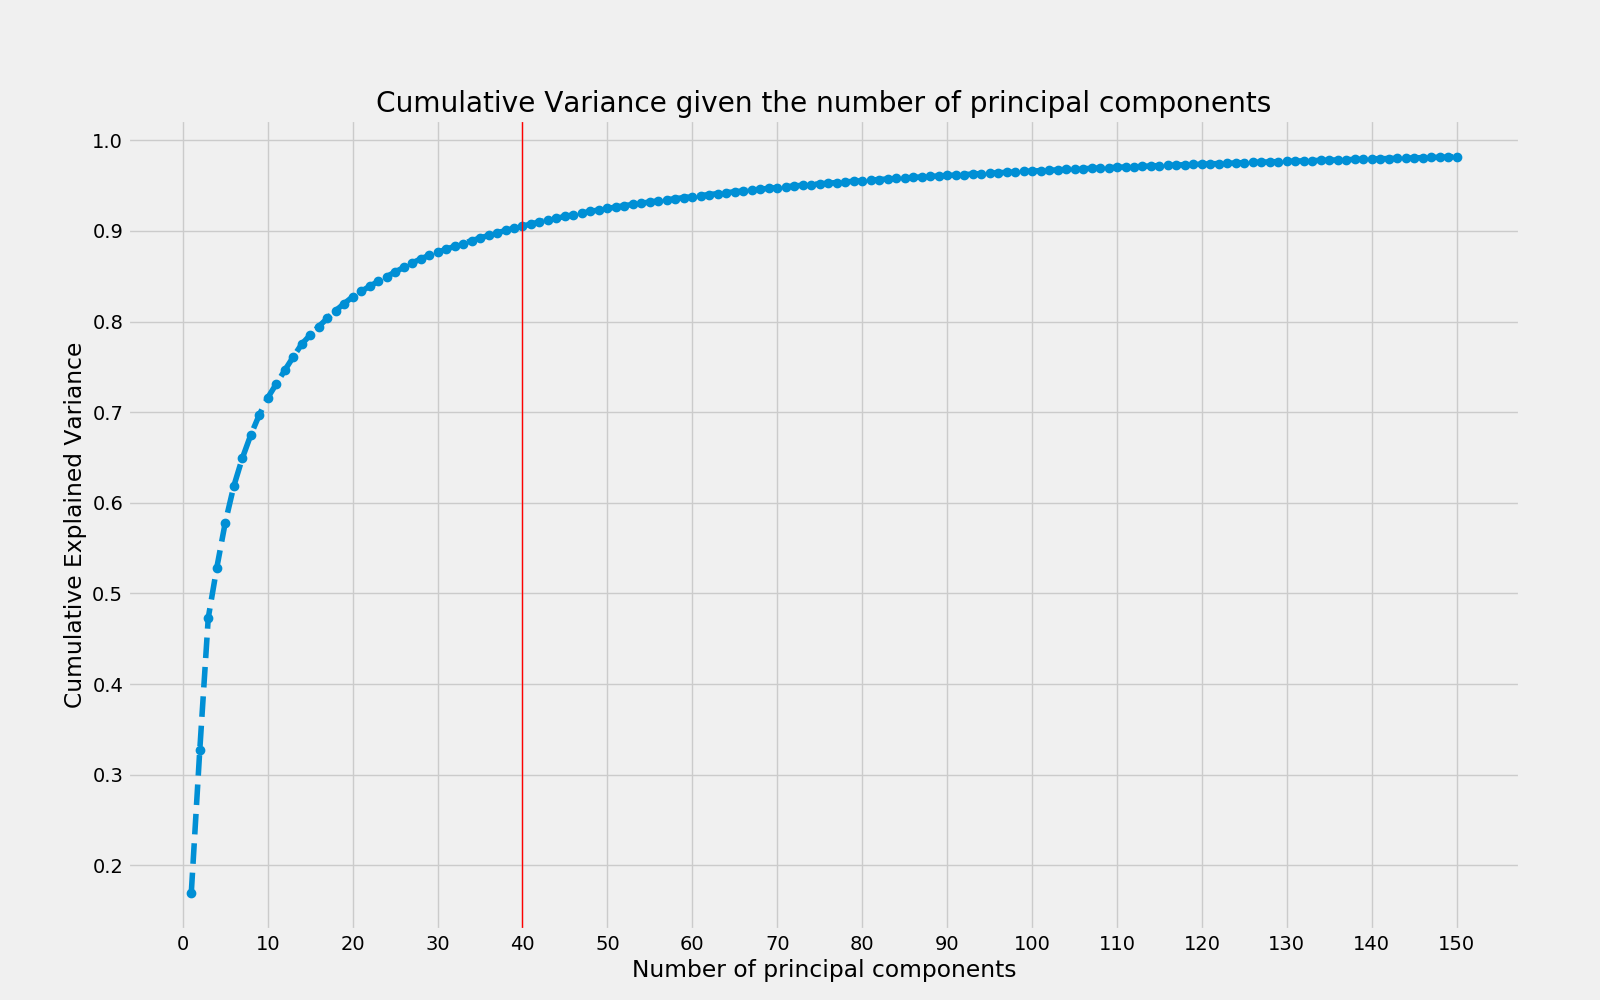

In [34]:
# Cumaltive Variance analysis (finding the right dimension for PCA)
pca = PCA(k=150, inputCol="features", outputCol="pca_features")
pca_model = pca.fit(df_vector)
cumValues = pca_model.explainedVariance.cumsum() # get the cumulative values

# plot 
plt.clf()
plt.figure(figsize=(16,10))
plt.plot(range(1,151), cumValues, marker = 'o', linestyle='--')
plt.xticks(range(0,151,10))
plt.title('Cumulative Variance given the number of principal components')
plt.xlabel('Number of principal components')
plt.ylabel('Cumulative Explained Variance')
plt.axvline(40,c='red',linewidth=1)
%matplot plt

We can see that with 40 components out of 355, we keep 90% of the variance of the original features and so we decide to map the features space from $\mathcal{R}^{355}$ to $\mathcal{R}^{40}$ using the first 40 Principal Component.

In [35]:
# PCA (from R^355 to R^40)
pca = PCA(k=40, inputCol="features", outputCol="pca_features")
pca_model = pca.fit(df_vector)
df_vector_projected = pca_model.transform(df_vector).select(['hashtag','pca_features']).withColumnRenamed('pca_features','features')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## KMeans
To perform KMeans we need first to know the appropriate numbers of clusters $K$. We use a range of candidates for $K$, and repetively we compute the Within Set Sum of Squared Error (WSSSE). This value is a measure of how close each data point is to its cluster. Then we choose $K$ by plotting the WSSSE score given the number of clusters, and considering a point in the elbow for a good tradeoff (low WSSSE and low $K$). 

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

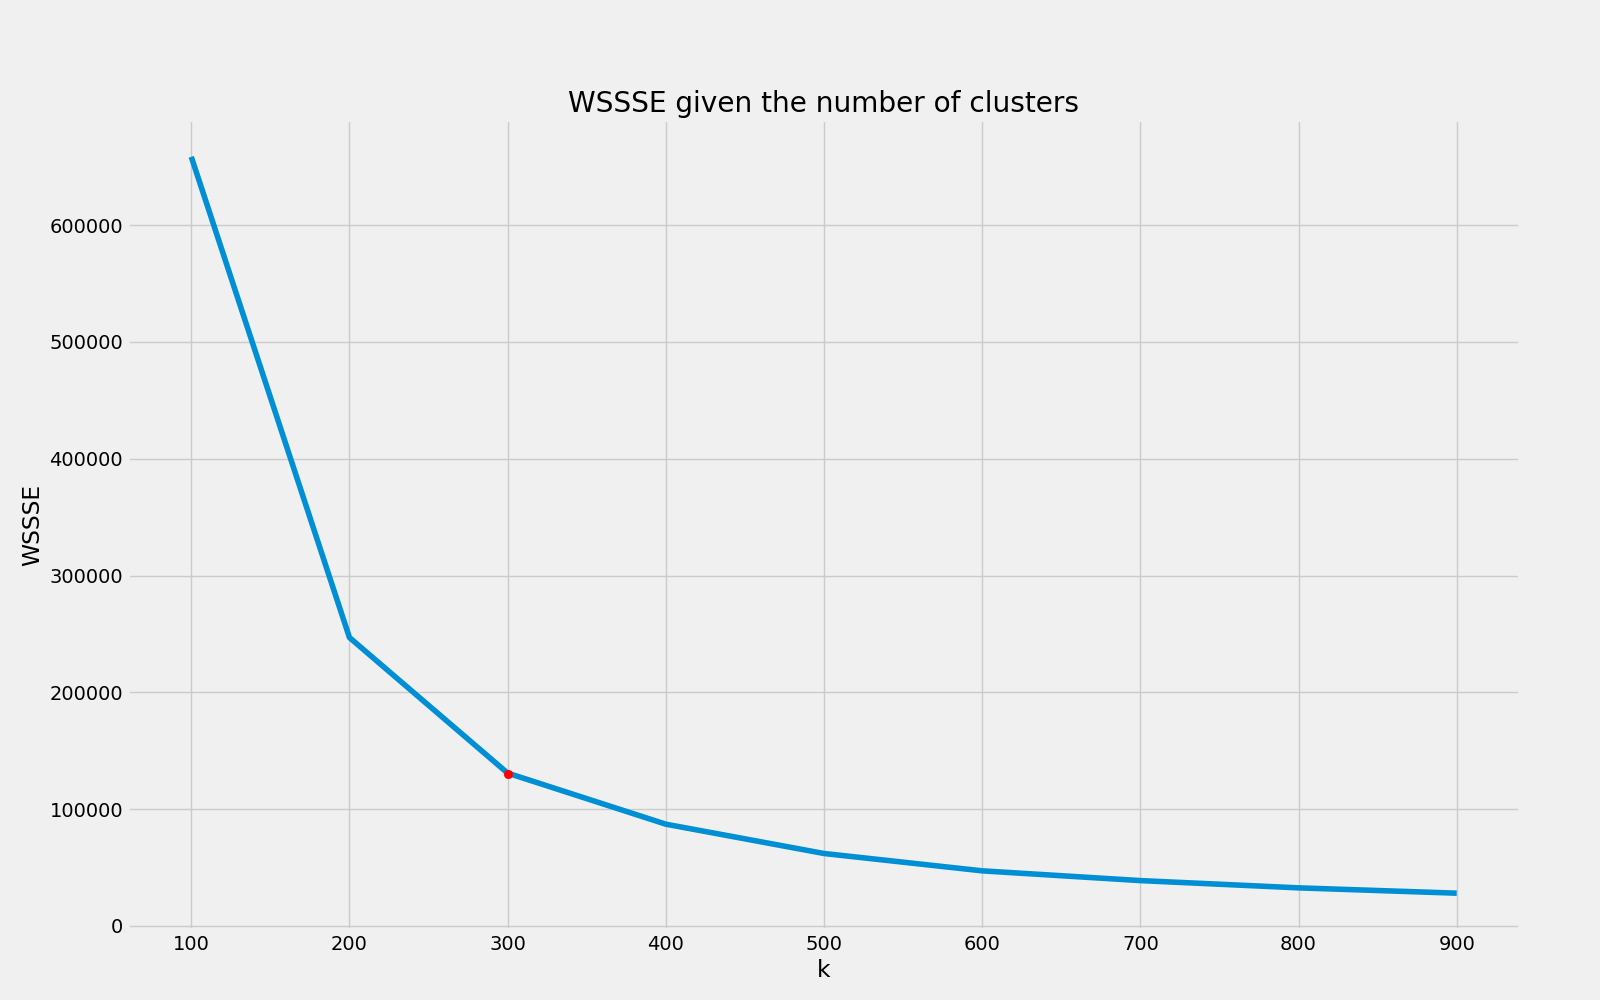

In [36]:
# Tuning the right number of clusters k for kmeans algorithms
WSSSE = []
kRange = range(100,1000,100)

for k in kRange:
    kmeans = KMeans().setK(k).setSeed(1L)
    model = kmeans.fit(df_vector_projected)
    #predictions = model.transform(df_vector_projected)

    WSSSE.append((model.computeCost(df_vector_projected))/(df_vector.count()))
    
# plot WSSSE as a function of k
plt.clf()
plt.figure(figsize=(16,10))
plt.plot(kRange,WSSSE,zorder=1)
plt.ylabel('WSSSE')
plt.xlabel('k')
plt.title('WSSSE given the number of clusters')
plt.scatter(x=300,y=130000, marker='o', c='r',zorder=2)
%matplot plt

Here $K=300$ seems to be a good number of clusters. KMeans is then computed on the PCA projection of the whole dataset. 

In [37]:
# KMEANS training
kmeans = KMeans().setK(300).setSeed(1L)
kmeans_model = kmeans.fit(df_vector_projected)
df_vector_projected = model.transform(df_vector_projected)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Validation
Since either the number of datapoints (hashtags) and the number of clusters ($K$) are big, it is quite difficult to evaluate the performances of the model. Then we decided to filter 3 three subsets of hahstags related to three different specific topics: Covid19 (pandemic), Oscars (event) and MAMA (music award); and evaluating on them our clustering.

#### Visualization
In the following 3 plots we show the time series of the number of daily hashtags published for each main hashtag related to these topics, showing that the hashtags related to the same topic follow a similar pattern.

In [38]:
def plot(hashtags, name):
    
    plot_df = daily_hashtag_matrix[daily_hashtag_matrix.hashtag.isin(hashtags)].toPandas().set_index("hashtag").transpose()
    base_date = datetime.datetime(2020,1,1)
    plot_df.index = plot_df.index.map(lambda t: base_date + datetime.timedelta(days=int(t)))

    plot_df.plot()
    plt.title("{}-related hashtags count time series".format(name))
    plt.xlabel("Day of year 2020")
    plt.ylabel("Number of hashtag occurences")
    plt.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

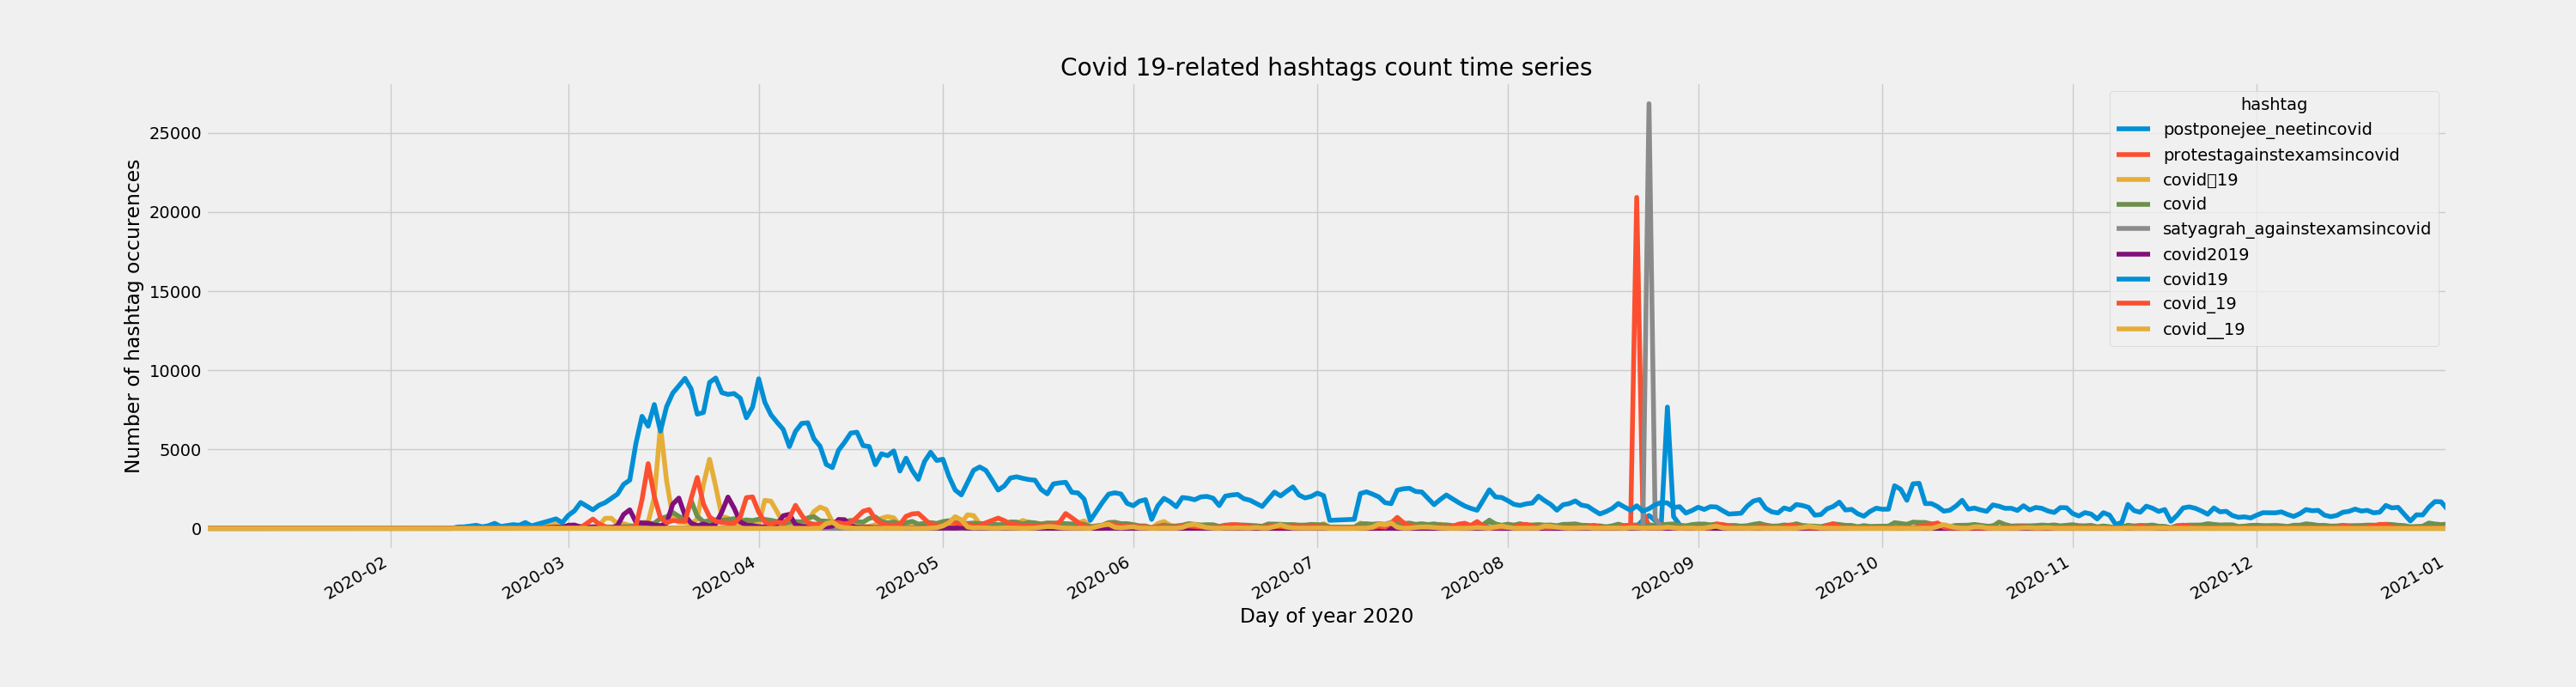

In [39]:
# COVID related hashtags
covid = english_df.groupBy("hashtag").count().sort("count", ascending=False).filter(df_vector.hashtag.like('%covid%')).where("count>10000")
covid_hashtags = [row['hashtag'] for row in covid.collect()]

plot(covid_hashtags, "Covid 19")
%matplot plt

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

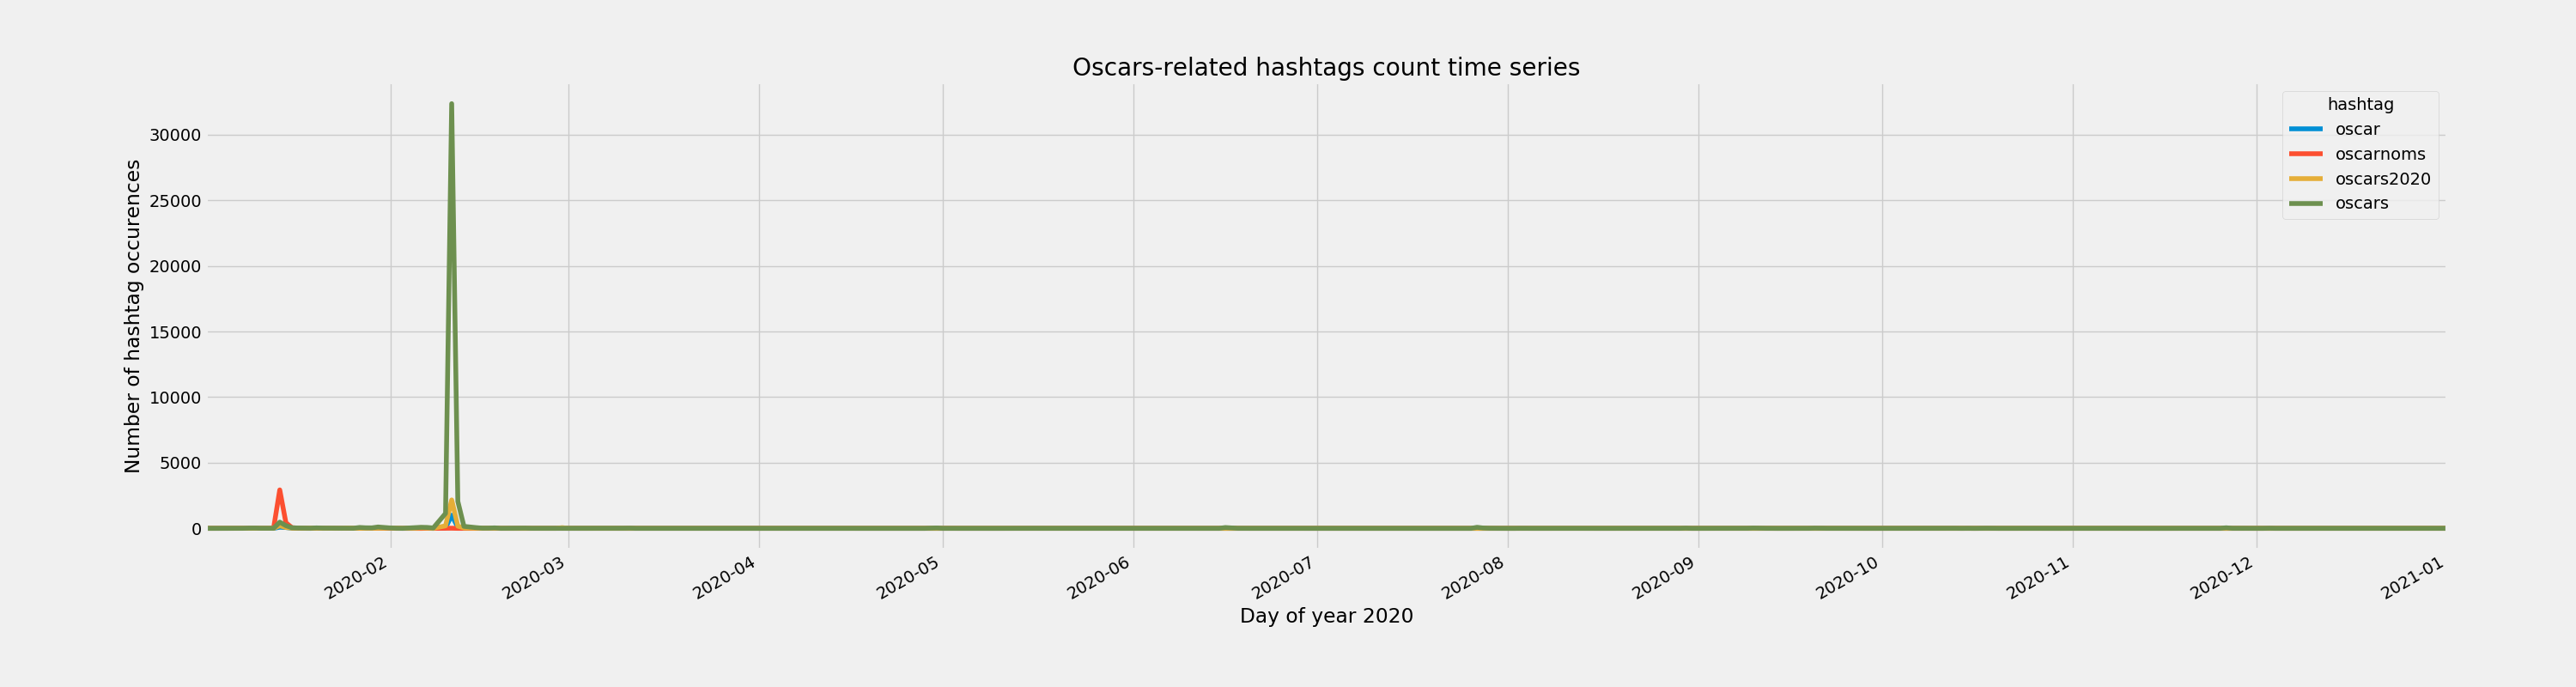

In [40]:
# OSCARS related hashtags
oscars = english_df.groupBy("hashtag").count().sort("count", ascending=False).filter(df_vector.hashtag.like('%oscar%' or '%parasite%')).where("count>1000")
oscars_hashtags = [row['hashtag'] for row in oscars.collect()]

plot(oscars_hashtags, "Oscars")
%matplot plt

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

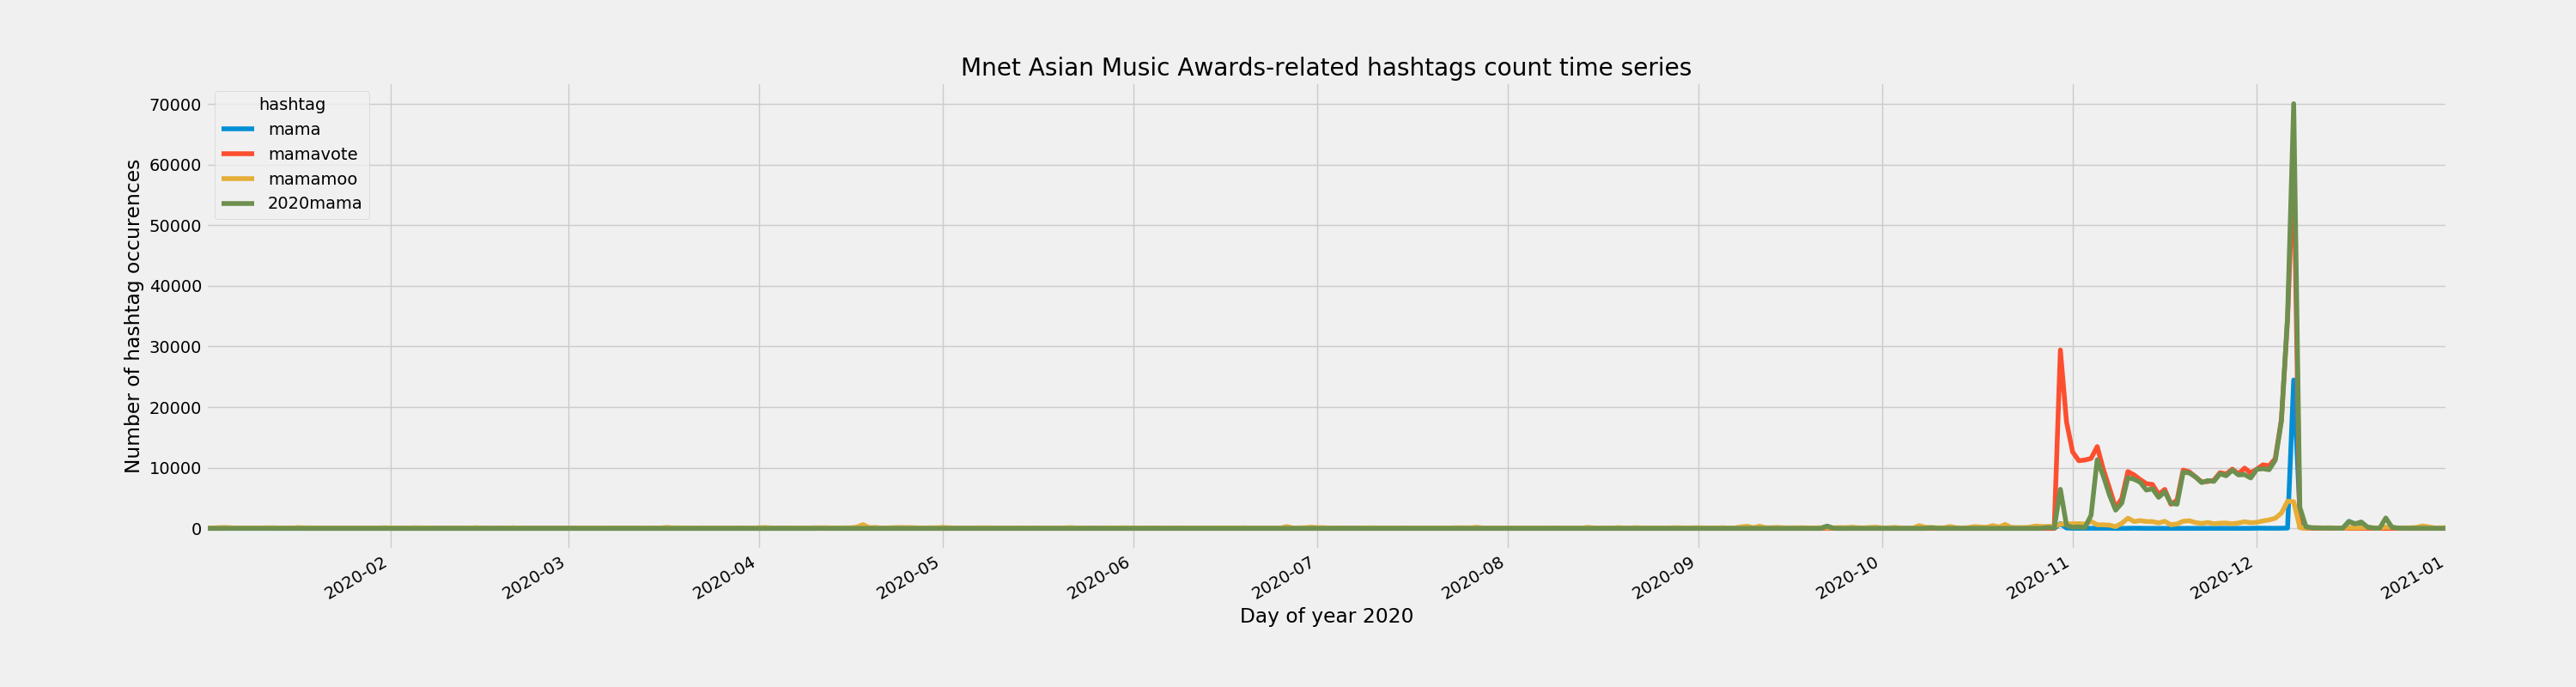

In [41]:
# MAMA related hashtags
mama = english_df.groupBy("hashtag").count().sort("count", ascending=False).filter(df_vector.hashtag.like('%mama%')).where("count>30000")
mama_hashtags = [row['hashtag'] for row in mama.collect()]

plot(mama_hashtags, "Mnet Asian Music Awards")
%matplot plt

In [42]:
# filter only Covid, Oscars and MAMA related hashtags from the dataset already projected in the first 40 principal component
COM_hashtags = covid_hashtags + oscars_hashtags + mama_hashtags
dataset_COM_projected = df_vector_projected.where(df_vector_projected.hashtag.isin(COM_hashtags))
dataset_COM_projected.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+----------+
|             hashtag|            features|prediction|
+--------------------+--------------------+----------+
|               oscar|[-4.9276772537358...|       612|
|                mama|[-223.65388389890...|       751|
|postponejee_neeti...|[-45.511148261277...|       552|
|           oscarnoms|[-1.6211113430389...|       470|
|protestagainstexa...|[-181.27218122865...|       308|
|            covidー19|[-130.04795718892...|       334|
|               covid|[-477.29907711364...|       131|
|satyagrah_against...|[-97.532034754792...|       409|
|           covid2019|[-29.758613235671...|       171|
|            mamavote|[-1667.9249251098...|         6|
|          oscars2020|[-6.4672841925431...|       107|
|             covid19|[-3659.5308144598...|       119|
|             mamamoo|[-344.14399106316...|       152|
|            covid_19|[-313.12123803587...|       579|
|              oscars|[-87.504842996576...|        32|
|         

Even focusing just on the three set of hashtags (Covid, Oscars and MAMA) we can see that k-Mean Algorithm using $K=300$ is not able to recognize and cluster hashtags releated to the same topics in the same way (almost all the hashtags considered are mapped in to a different cluster). This is due by the high number of clusters that we are imposing that could split the hashtags in more and different ways.

So we wonder if there is at least a different geometric distribution between the 3 different topics considered.
Unfortunately, any comprehensive plot of the data points (hashtags) in the whole tranformed features space $\mathcal{R}^{40}$ is impossible in a webpage of 2 dimension, then, just to give an approximative idea of their distribution we plot them considering only the first 2 (most important) principal components.

In [43]:
# color tag for each topic
def colorMap(x):
    if ('covid') in x:
        return 'blue'
    elif ('mama') in x:
        return 'red'
    else: 
        return 'green'

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

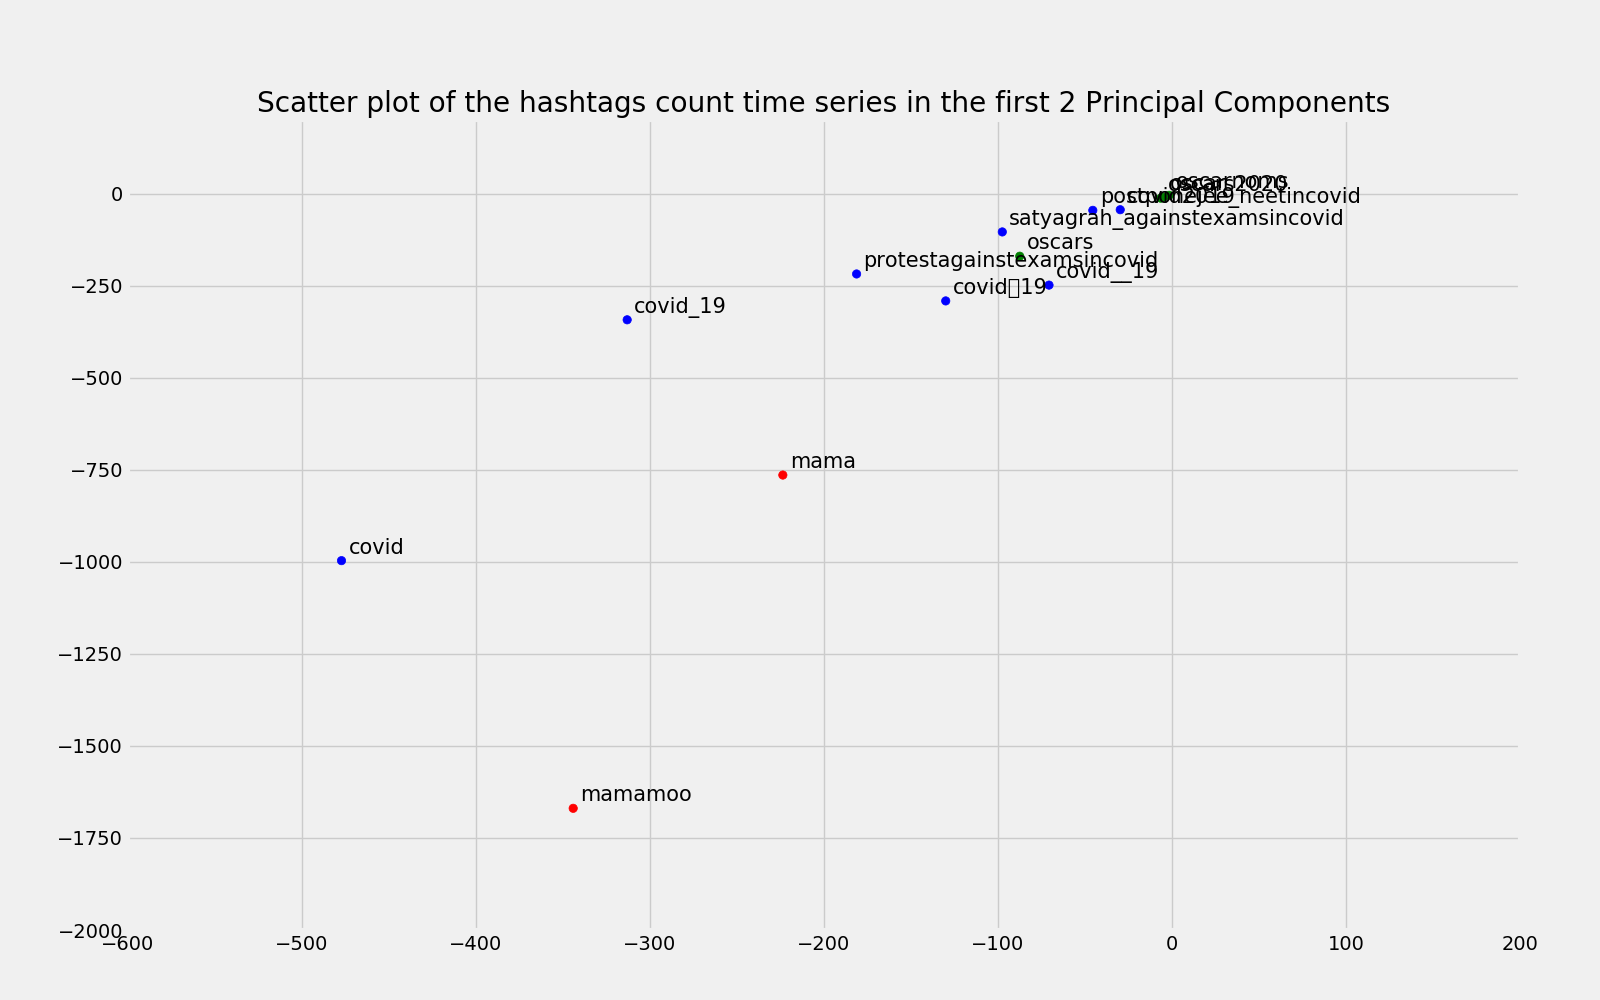

In [44]:
# Visualization of the hashtags in the first 2 principal components
x_pca = [x[0][0] for x in dataset_COM_projected.select('features').collect()] 
y_pca = [x[0][1] for x in dataset_COM_projected.select('features').collect()] 
names = [x[0] for x in dataset_COM_projected.select('hashtag').collect()]
colors = [(colorMap(x[0])) for x in dataset_COM_projected.select('hashtag').collect()]

plt.clf()
plt.ylabel('y')
plt.xlabel('x')
plt.figure(figsize=(16,10))
plt.xlim(-600,200)
plt.ylim(-2000,200)

plt.title('Scatter plot of the hashtags count time series in the first 2 Principal Components')
plt.scatter(x_pca,y_pca,c=colors)
for i, txt in enumerate(names):
    plt.annotate(txt, (x_pca[i], y_pca[i]),fontsize=15,xytext= (5,5), textcoords='offset points')
%matplot plt

Even if this representation is quite reductive (only 2 dimension are considered) we can see that a different geometric distribution between the 3 different topics really exists and so an unsupervised clustering of the dataset could actually be a promising idea. We can observe that almost all the hashtags Oscars related are very close each other, and more or less also the Covid related and MAMA related. It is also interesting to observe that there are few hashtags Covid related, such as `#satyagraha_againstexamsincovid` and `postponejee_neetincovid`, that are really close to the hashtags Oscars reated. In fact, the 2 hashtags just mentioned, contain the world 'covid' in their name, although they are not related to the pendemic in general, but to a specific student movement/event in India which took place the 23 August 2020. Actually their count time series is more similar to that one of an event (like Oscars night) rather than that one of the evolution of the pandemic.

A even better reppresentation in $\mathcal{R}^2$ of this few hashtags can be generated training the PCA only on themselves.

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

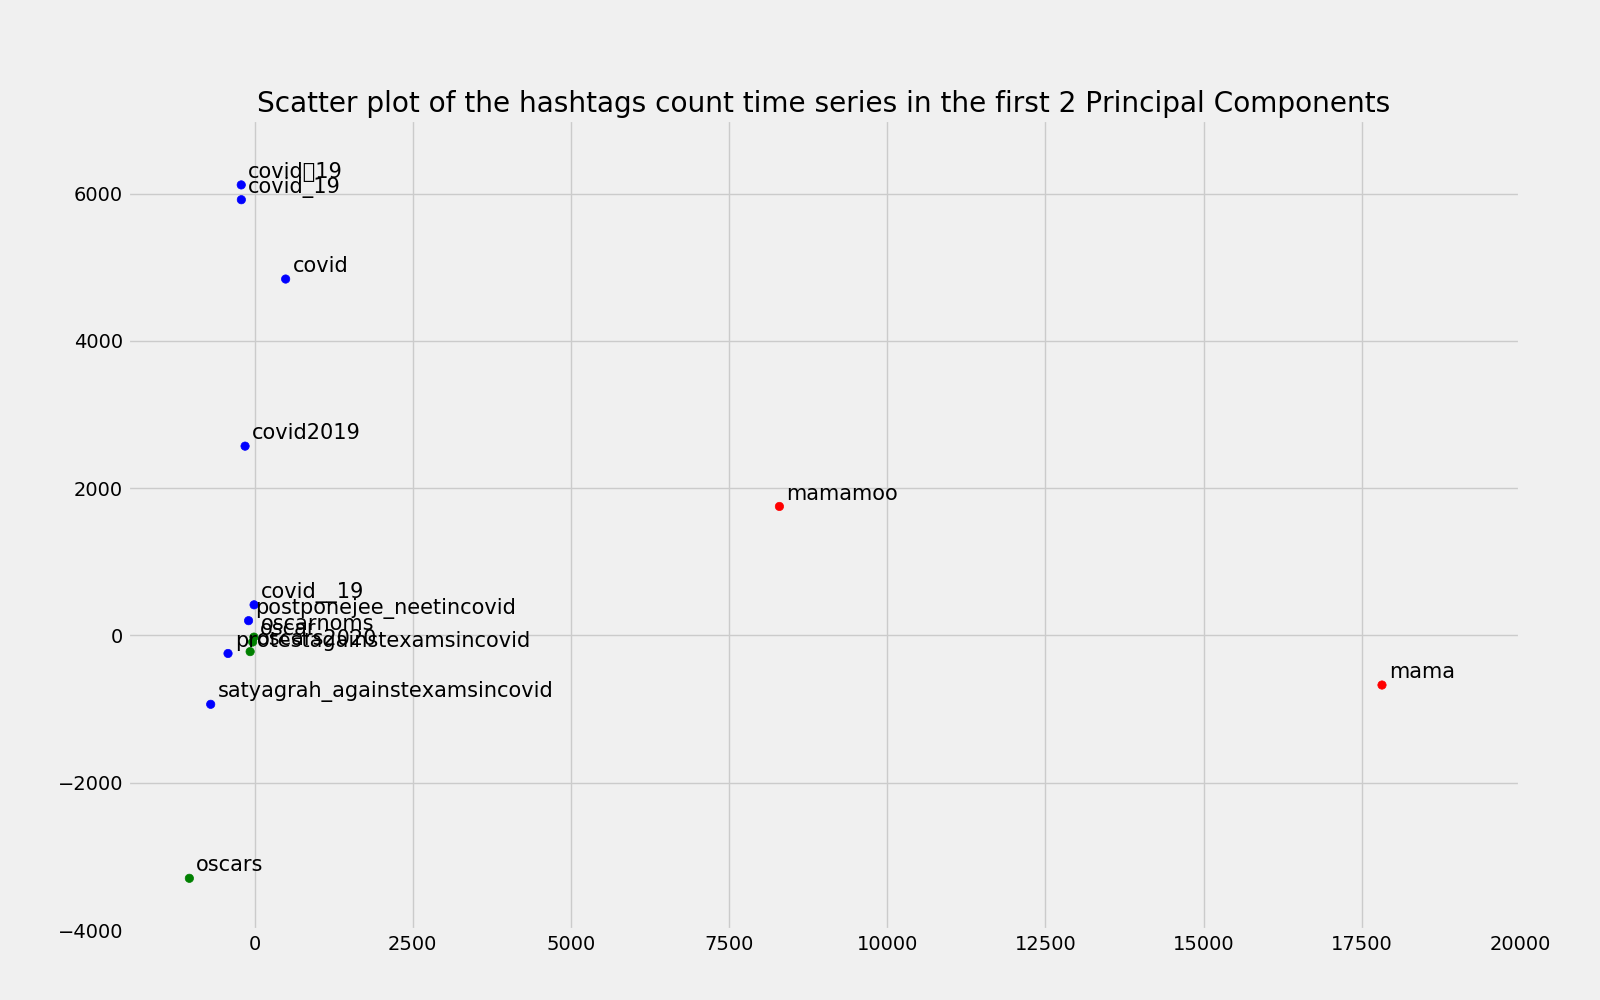

In [45]:
# filter only Covid, Oscars and MAMA related hashtags from the dataset (not trasformed)
COM_hashtags = covid_hashtags + oscars_hashtags + mama_hashtags
dataset_COM = df_vector.where(df_vector.hashtag.isin(COM_hashtags))

# PCA (from R^355 to R^40)
pca = PCA(k=40, inputCol="features", outputCol="pca_features")
pca_model = pca.fit(dataset_COM)
dataset_COM_projected = pca_model.transform(dataset_COM).select(['hashtag','pca_features']).withColumnRenamed('pca_features','features')

# Visualization of the hashtags in the first 2 principal components
x_pca = [x[0][0] for x in dataset_COM_projected.select('features').collect()] 
y_pca = [x[0][1] for x in dataset_COM_projected.select('features').collect()] 
names = [x[0] for x in dataset_COM_projected.select('hashtag').collect()]
colors = [(colorMap(x[0])) for x in dataset_COM_projected.select('hashtag').collect()]

plt.clf()
plt.ylabel('y')
plt.xlabel('x')
plt.figure(figsize=(16,10))
plt.xlim(-2000,20000)
plt.ylim(-4000,7000)

plt.title('Scatter plot of the hashtags count time series in the first 2 Principal Components')
plt.scatter(x_pca,y_pca,c=colors)
for i, txt in enumerate(names):
    plt.annotate(txt, (x_pca[i], y_pca[i]),fontsize=15,xytext= (5,5), textcoords='offset points')
%matplot plt

#### Conclusion
We can finally conclude that an Unsupervised clustering of the dataset seems very promising to spot if there are clusters of hashtags with similar count times series (and hopefully thematically similar).

# That's all, folks!